# Using pynoddy to generate features in geological model space

In [2]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [3]:
import sys, os
import matplotlib.pyplot as plt
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy.history

In [4]:
%matplotlib inline

In [5]:
reload(pynoddy.history)
reload(pynoddy.events)
reload(pynoddy)
history = "feature_model.his"
output_name = "feature_out"
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 5,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3',
                                   'layer 4', 'layer 5'],
                  'layer_thickness' : [1500, 500, 500, 1500, 500]}
nm.add_event('stratigraphy', strati_options )

fold_options = {'name' : 'Fold',
                 'pos' : (4000, 3500, 5000),
                 'amplitude' : 200,
                'dip_dir' : 135.0,
                 'wavelength' : 5000}

nm.add_event('fold', fold_options)

# The following options define the fault geometry:
fault_options = {'name' : 'Fault_W',
                 'pos' : (4000, 3500, 5000),
                 'dip_dir' : 90,
                 'dip' : 60,
                 'slip' : 1000}

nm.add_event('fault', fault_options)
# The following options define the fault geometry:
fault_options = {'name' : 'Fault_E',
                 'pos' : (6000, 3500, 5000),
                 'dip_dir' : 270,
                 'dip' : 60,
                 'slip' : 1000}

nm.add_event('fault', fault_options)
nm.write_history(history)

In [6]:
# Change cube size
nm1 = pynoddy.history.NoddyHistory(history)
nm1.change_cube_size(100)
nm1.write_history(history)

In [7]:
# Compute the model
pynoddy.compute_model(history, output_name) 

''

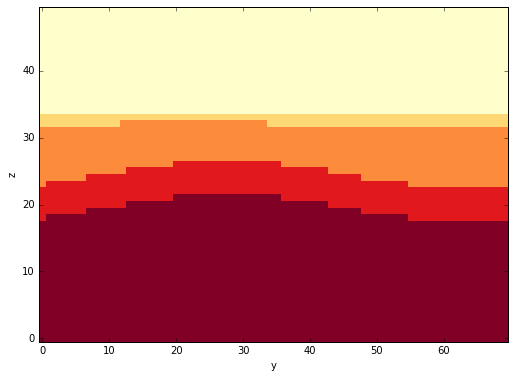

In [8]:
# Plot output
import pynoddy.output
reload(pynoddy.output)
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('x', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_faults_combined.eps",
                  cmap = 'YlOrRd') # note: YlOrRd colourmap should be suitable for colorblindness!

In [42]:
nout.export_to_vtk(vtk_filename = "feature_model")

In [43]:
import os
history_file = os.path.join(repo_path, "examples/GBasin_Ve1_V4.his")

In [44]:
his_gipps = pynoddy.history.NoddyHistory(history_file)

In [45]:
his_gipps.events[2].properties

{'Amplitude': 500.0,
 'Cylindricity': 0.0,
 'Dip': 90.0,
 'Dip Direction': 90.0,
 'Pitch': 0.0,
 'Single Fold': 'FALSE',
 'Type': 'Sine',
 'Wavelength': 15000.0,
 'X': 0.0,
 'Y': 0.0,
 'Z': 0.0}

In [46]:
import numpy as np
np.unique(nout.block)

array([ 1.,  2.,  3.,  4.,  5.])

## Adding features to geological layers

The first step is to define the covariance matrix and mean values for all features and for all geological units. Then, for each cell in the model, a random feature value is generated.

For this test, we consider the following model:
- each layer has a different feature mean value
- the covariance matrix is identical for all layers (assuming some physical relationship, for examlpe between porosity/ permability; or density, vp)


In [47]:
cov = [[0.08, 0.0, 0.],
       [0.0, 0.01, 0.],
       [0., 0., 0.05]]

# define mean values for features
feature1_means = [1.0, 1.5, 1.2, 1.0, 1.2]
feature2_means = [5.1, 5.2, 5.12, 5.0, 5.1]
feature3_means = [1.0, 1.2, 1.4, 1.6, 1.8]

# resort into unit means
means_units = [[m1, m2, m3] for m1, m2, m3 in 
               zip(feature1_means, feature2_means, feature3_means)]
print means_units, np.array(cov)**0.5

[[1.0, 5.1, 1.0], [1.5, 5.2, 1.2], [1.2, 5.12, 1.4], [1.0, 5.0, 1.6], [1.2, 5.1, 1.8]] [[ 0.28284271  0.          0.        ]
 [ 0.          0.1         0.        ]
 [ 0.          0.          0.2236068 ]]


In [48]:
print np.sqrt(cov)

[[ 0.28284271  0.          0.        ]
 [ 0.          0.1         0.        ]
 [ 0.          0.          0.2236068 ]]


In [49]:
f1, f2, f3 = np.random.multivariate_normal(means_units[0], cov, 1000).T

In [50]:
n1 = int(np.sum(nout.block[nout.block == 1.0]))

In [51]:
# sample for geological unit 1
f1, f2, f3 = np.random.multivariate_normal(means_units[0], cov, n1).T

In [52]:
tmp = np.copy(nout.block)

In [53]:
tmp[tmp == 1.0] = f1

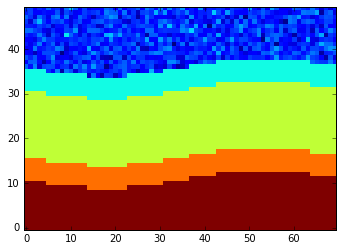

In [54]:
plt.imshow(tmp[0,:,:].T, origin = 'lower_left', interpolation = 'nearest')

ok, seems to work - now for all:

In [55]:
# create empty feature fields:
feature_field_1 = np.copy(nout.block)
feature_field_2 = np.copy(nout.block)
feature_field_3 = np.copy(nout.block)

for unit_id in np.unique(nout.block):
    print unit_id
    n_tmp = int(np.sum(nout.block == unit_id))
    f1, f2, f3 = np.random.multivariate_normal(means_units[int(unit_id-1)], cov, n_tmp).T
    feature_field_1[feature_field_1 == unit_id] = f1
    feature_field_2[feature_field_2 == unit_id] = f2
    feature_field_3[feature_field_3 == unit_id] = f3


1.0
2.0
3.0
4.0
5.0


In [56]:
# Export feature fields to VTK (via pynoddy output file)
nout.block = feature_field_1
nout.export_to_vtk(vtk_filename = "feature_field_1")
nout.block = feature_field_2
nout.export_to_vtk(vtk_filename = "feature_field_2")
nout.block = feature_field_3
nout.export_to_vtk(vtk_filename = "feature_field_3")

In [57]:
# write to feature file for Jack
feature_file = open("features_midres_2.csv", 'w')
feature_file.write("x, y, z, f1, f2, f3\n")
for zz in range(nout.nz):
    for yy in range(nout.ny):
        for xx in range(nout.nx):
            feature_file.write("%d, %d, %d, %.5f, %.5f, %.5f\n" %
                              (xx, yy, zz, feature_field_1[xx, yy, zz],
                               feature_field_2[xx, yy, zz], feature_field_3[xx, yy, zz]))
feature_file.close()
                                                        

In [9]:

# Export labels:
nout = pynoddy.output.NoddyOutput(output_name)
label_file = open("labels.csv", 'w')
label_file.write("x, y, z, label\n")
for zz in range(nout.nz):
    for yy in range(nout.ny):
        for xx in range(nout.nx):
            label_file.write("%d, %d, %d, %df\n" %
                              (xx, yy, zz, nout.block[xx,yy,zz]))
label_file.close()

